In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tarfile
import os
import fnmatch
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision
from torchvision import models
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
fname = 'line_3.tar'
ap = tarfile.open(fname)
ap.extractall('./line')
ap.close()
data_dir = './line/line'
file_list = os.listdir(data_dir)
image_paths = []
states = []
mask=[]
pattern = "*.png"
for filename in file_list:
  if fnmatch.fnmatch(filename, pattern):
    image_paths.append(os.path.join(data_dir,filename))
    state = str(filename[-5:-4])
    states.append(state)
images = [cv2.imread(img) for img in image_paths]
print(type(images))

def region_of_interest(img,vertices):
    mask=np.zeros_like(img)
    if len(img.shape)>2:
        channel_count=img.shape[2]
        ignore_mask_color=(255,)*channel_count
    else:
        ignore_mask_color=255
    cv2.fillPoly(mask,vertices,ignore_mask_color)
    masked_image=cv2.bitwise_and(img,mask)
    masked_image=cv2.resize(masked_image,(224,224))
    return masked_image

vertices = np.array([[(0, 480), (100, 300), (500, 300), (640, 480)]], dtype=np.int32)

for i in range(len(images)):
  mask.append(region_of_interest(images[i],vertices))

L_data = []
R_data = []
G_data = []
S_data = []
E_data = []

for i in range(len(states)):
  if states[i] == "L":
    L_data.append(mask[i])
  elif states[i] == "R":
    R_data.append(mask[i])
  elif states[i] == "G":
    G_data.append(mask[i])
  elif states[i] == "S":
    S_data.append(mask[i])
  elif states[i] == "E":
    E_data.append(mask[i])

mask = []
states = []

for i in range(len(L_data)):
  mask.append(L_data[i])
  states.append("L")
for i in range(len(R_data)):
  mask.append(R_data[i])
  states.append("R")
for i in range(len(G_data)):
  mask.append(G_data[i])
  states.append("G")
for i in range(len(S_data)):
  mask.append(S_data[i])
  states.append("S")
for i in range(len(E_data)):
  mask.append(E_data[i])
  states.append("E")

df = pd.DataFrame()
df['state'] = states
df['state'].value_counts()
from sklearn.preprocessing import LabelEncoder
# OneHotEncoder 생성 및 학습 데이터에 fit
onehot_encoder = OneHotEncoder(sparse=False)
labels_encoded = onehot_encoder.fit_transform(np.array(['G', 'L', 'R', 'S', 'E']).reshape(-1, 1))
transform = transforms.Compose([
                                #transforms.RandomHorizontalFlip(),
                                #transforms.RandomCrop((320, 640), padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
class CustomDataset(Dataset):
    def __init__(self, mask, states, transform=None,validation=False, test=False, train=True, onehot_encoder=None):
        self.mask = mask
        self.states = states
        self.transform = transform
        self.train = train
        self.test = test
        self.validation = validation
        self.onehot_encoder = onehot_encoder
        # 데이터셋을 train과 test로 나누기
        train_size = int(0.8 * len(self.mask))
        test_size = int(len(self.mask)*0.2)
        validation_size = int(train_size*0.2)
        # train_test_split 함수를 사용하여 한 번에 데이터를 나누기
        remaining_data, test_data = train_test_split(list(zip(self.mask, self.states)), test_size = test_size, random_state=42)
        train_data, validation_data = train_test_split(remaining_data, test_size = validation_size, random_state=42)
        if self.train:
            self.data = train_data
        elif self.test:
            self.data = test_data
        elif self.validation:
            self.data = validation_data
    def __len__(self):
        return len(self.data)
    # def __getitem__(self, idx):
    #     img_path, state = self.data[idx]
    #     img = Image.fromarray(np.asarray(img_path)).convert('RGB')
    #     if self.transform:
    #         img = self.transform(img)
    #     # state를 숫자로 라벨링
    #     state = self.label_encoder.transform([state])[0]
    #     return img, state
    def __getitem__(self, idx):
        img_path, state = self.data[idx]
        img = Image.fromarray(np.asarray(img_path)).convert('RGB')
        if self.transform:
            img = self.transform(img)
        # state를 숫자로 라벨링
        # state = self.label_encoder.transform([state])[0]
        # state = torch.tensor(state, dtype=torch.long)  # Long 타입으로 변환
        # state를 원-핫 인코딩
        state_encoded = self.onehot_encoder.transform(np.array(state).reshape(-1, 1))[0]
        # cv2.imshow("img_path",img_path)
        # cv2.waitKey(0)
        # plt.imshow(img_path)
        # plt.show()
        # print("state", state)
        return img, state_encoded
# 훈련 데이터에 대해 OneHotEncoder 학습
onehot_encoder.fit(np.array(['G', 'L', 'R', 'S', 'E']).reshape(-1, 1))
# 훈련 및 테스트 데이터셋 생성
train_dataset = CustomDataset(mask=mask, states=states, transform=transform, train=True, validation=False, test=False, onehot_encoder=onehot_encoder)
test_dataset = CustomDataset(mask=mask, states=states, transform=transform, train=False, validation=False, test=True, onehot_encoder=onehot_encoder)
validation_dataset = CustomDataset(mask=mask, states=states, transform=transform, train=False, validation=True, test=False, onehot_encoder=onehot_encoder)
# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=10, shuffle=False)
# 간단한 CNN 모델 정의
class RoadClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(RoadClassifier, self).__init__()
        #self.cnn = models.resnet18(pretrained=True)
        # self.cnn = models.mobilenet_v2(pretrained=True)
        # in_features = self.cnn.classifier[-1].in_features #mobilenet_v2
        # self.cnn.classifier[-1] = nn.Linear(in_features, num_classes)
        # in_features = self.cnn.fc.in_features #ResNet18
        # self.cnn.fc = nn.Linear(in_features, num_classes)
        # shufflenet
        self.cnn = models.shufflenet_v2_x0_5(pretrained=True)
        in_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Linear(in_features, num_classes)
    def forward(self, x):
        return self.cnn(x)
# 모델, 손실 함수, 최적화기 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RoadClassifier(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# 학습하기
r_loss=[]
v_loss=[]
ep=[]
num_epochs = 40
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #print('outputs', outputs[0], 'labels', labels[0])

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    #print(f"Epoch {epoch+1}, Loss: {running_loss / i}")

    model.eval()  # 모델을 평가 모드로 전환
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for data_val in validation_loader:
            images_val, labels_val = data_val
            images_val, labels_val = images_val.to(device), labels_val.to(device)
            outputs_val = model(images_val)
            loss_val = criterion(outputs_val, labels_val)
            running_val_loss += loss_val.item()

            predicted_val = torch.argmax(outputs_val.data, dim=1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == torch.argmax(labels_val, dim=1)).sum().item()

    accuracy_val = 100 * correct_val / total_val
    average_val_loss = running_val_loss / len(validation_loader)

    print(f"에폭 {epoch+1}, 훈련 손실: {running_loss / i}, 검증 손실: {average_val_loss}, 검증 정확도: {accuracy_val}%")
    r_loss.append(running_loss)
    v_loss.append(running_val_loss)
    ep.append(epoch+1)

    # with torch.no_grad():
    #     for data in validation_loader:
    #         images_val, labels_val = data
    #         images_val, labels_val = images_val.to(device), labels_val.to(device)
    #         outputs_val = model(images_val)
    #         predicted_val = torch.argmax(outputs_val.data, dim=1)
    #         total_val += labels_val.size(0)
    #         correct_val += (predicted_val == torch.argmax(labels_val, dim=1)).sum().item()

    # accuracy_val = 100 * correct_val / total_val
    # print(f"Epoch {epoch+1}, Loss: {running_loss / i}, Validation Accuracy: {accuracy_val}%")
    model.train()  # 모델을 다시 학습 모드로 전환
print("학습 완료")
# 검증하기

# 테스트하기
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
print(f"Accuracy: {100 * correct / total}%")

# # 테스트하기
# correct = 0
# total = 0

# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         predicted = torch.argmax(outputs.data, dim=1)
#         total += labels.size(0)
#         correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

#         # 개별적으로 비교하여 이미지 출력
#         for i in range(len(predicted)):
#             if predicted[i] != torch.argmax(labels[i], dim=0):
#                 # 이미지를 CPU로 이동하고 시각화
#                 img_to_show = images[i].cpu().permute(1, 2, 0)
#                 plt.imshow(img_to_show)
#                 plt.show()
#                 print(f'에측: ', predicted[i], '레이블: ', torch.argmax(labels[i], dim=0))

# accuracy = 100 * correct / total
# print(f"Accuracy: {accuracy}%")

torch.save(model.state_dict(), 'road_classifier_model_shuffle_end.pth')
# loaded_model = RoadClassifier(num_classes=3).to(device)
# loaded_model.load_state_dict(torch.load('road_classifier_model.pth'))
# loaded_model.eval()

<class 'list'>


c:\Users\dohye\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\dohye\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\dohye\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dohye\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior i

에폭 1, 훈련 손실: 1.6982854787319428, 검증 손실: 1.5961017231146495, 검증 정확도: 16.666666666666668%
에폭 2, 훈련 손실: 1.6433596958243657, 검증 손실: 1.5500250299771625, 검증 정확도: 50.0%
에폭 3, 훈련 손실: 1.5741794474541195, 검증 손실: 1.4603449920813243, 검증 정확도: 63.888888888888886%
에폭 4, 훈련 손실: 1.4839725418696328, 검증 손실: 1.3414722422758736, 검증 정확도: 63.888888888888886%
에폭 5, 훈련 손실: 1.3746633776123562, 검증 손실: 1.2286204427480698, 검증 정확도: 63.888888888888886%
에폭 6, 훈련 손실: 1.2544007439935019, 검증 손실: 1.1140729506810507, 검증 정확도: 63.888888888888886%
에폭 7, 훈련 손실: 1.1319735647667024, 검증 손실: 1.0130579963326456, 검증 정확도: 63.888888888888886%
에폭 8, 훈련 손실: 1.0137339710006639, 검증 손실: 0.9284098212917646, 검증 정확도: 66.66666666666667%
에폭 9, 훈련 손실: 0.9035138597564093, 검증 손실: 0.8511478589226802, 검증 정확도: 66.66666666666667%
에폭 10, 훈련 손실: 0.805042152171807, 검증 손실: 0.7872046240915855, 검증 정확도: 66.66666666666667%
에폭 11, 훈련 손실: 0.7210353716616593, 검증 손실: 0.7338912675778071, 검증 정확도: 69.44444444444444%
에폭 12, 훈련 손실: 0.6513062738739546, 검증 손실: 0.692117

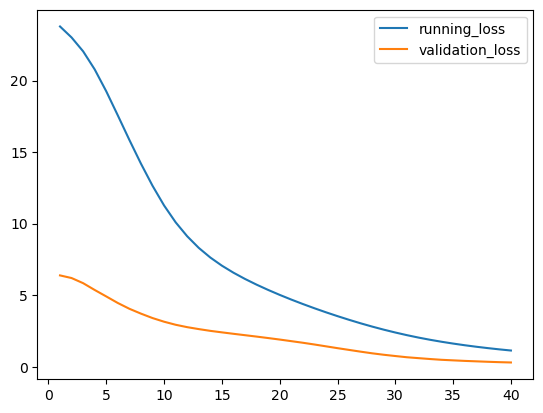

In [15]:
import matplotlib.pyplot as plt
plt.plot(ep, r_loss, label='running_loss')
plt.plot(ep, v_loss, label='validation_loss')
plt.legend()
plt.show()


In [40]:
transform = transforms.Compose([
                                #transforms.RandomHorizontalFlip(),
                                #transforms.RandomCrop((320, 640), padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

model = RoadClassifier()
model.load_state_dict(torch.load('road_classifier_model.pth'))
model.eval()

c:\Users\dohye\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dohye\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RoadClassifier(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

image=0


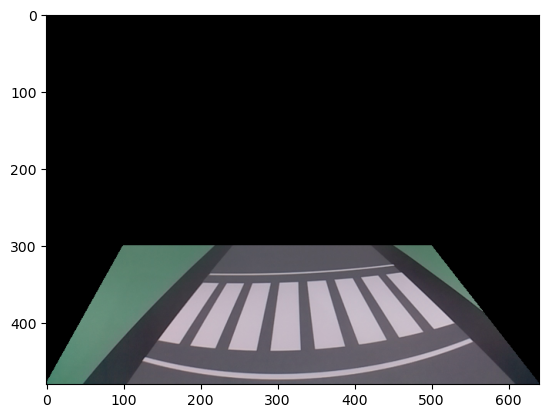

image=1


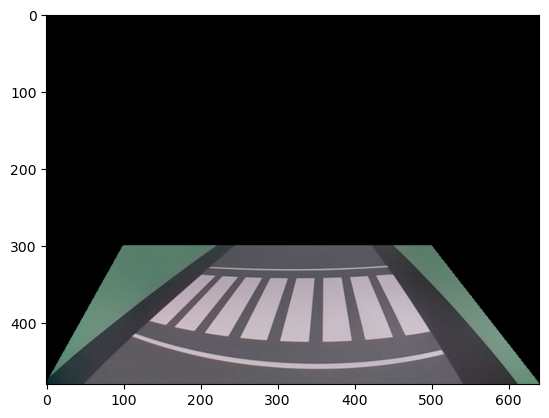

image=2


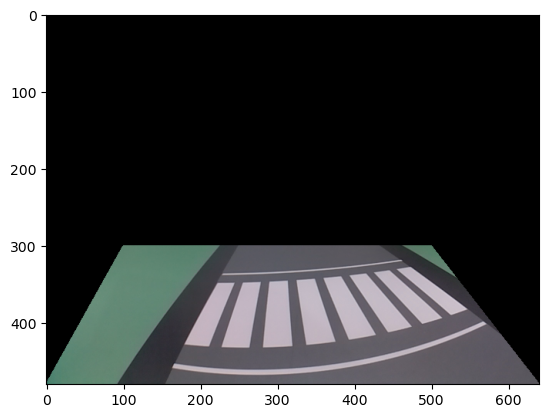

AttributeError: 'NoneType' object has no attribute 'shape'

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#model.eval()
def region_of_interest(img,vertices):
    mask=np.zeros_like(img)

    if len(img.shape)>2:
        channel_count=img.shape[2]
        ignore_mask_color=(255,)*channel_count
    else:
        ignore_mask_color=255

    cv2.fillPoly(mask,vertices,ignore_mask_color)
    
    masked_image=cv2.bitwise_and(img,mask)
    return masked_image
#image = mpimg.imread('./line/line/_00021_L.png')

vertices = np.array([[(0,480),(100, 300), (500, 300), (640,480)]], dtype=np.int32)

for i in range(0,5):
    img = cv2.imread(f'./line/line/_0000{i}_S.png')
    mask=region_of_interest(img,vertices)
    print(f'image={i}')
    plt.imshow(mask)
    plt.show()


  
# print('This image is:', type(image), 'with dimensions:', image.shape)

# a = Image.fromarray(np.asarray(img)).convert('RGB')

# # 이미지 변환 및 차원 추가
# transformed_image = transform(a).unsqueeze(0).to(device='cuda')  # 모델이 있는 장치로 이동

# result = model(transformed_image)
# print(result)

#L데이터 48,49


In [5]:
# model.eval()
cap = cv2.VideoCapture(0)  # 0 또는 1 등 적절한 카메라 인덱스 사용

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    a = Image.fromarray(np.asarray(frame)).convert('RGB')

    # 이미지 변환 및 차원 추가
    transformed_image = transform(a).unsqueeze(0).to(device='cpu')

    result = model(transformed_image)
    # print(result)
    predicted_class = torch.argmax(result).item()

    cv2.putText(frame, f'Prediction: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Frame', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(33) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [25]:
model.eval()
img=cv2.imread('./line/line/_00000_L.png')

a = Image.fromarray(np.asarray(img)).convert('RGB')

# 이미지 변환 및 차원 추가
transformed_image = transform(a).unsqueeze(0).to(device='cuda')

result = model(transformed_image)
# print(result)
predicted_class = torch.argmax(result).item()

cv2.putText(img, f'Prediction: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2.imshow('Frame', img)

    # Break the loop if 'q' is pressed
cv2.waitKey(0) & 0xFF == ord('q')

cv2.destroyAllWindows()

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numpy array, neither a scalar
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'


In [3]:
import cv2
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models

class RoadClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(RoadClassifier, self).__init__()
        self.cnn = models.resnet18(pretrained=True)
        in_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.cnn(x)
    
def region_of_interest(img,vertices):
    mask=np.zeros_like(img)

    if len(img.shape)>2:
        channel_count=img.shape[2]
        ignore_mask_color=(255,)*channel_count
    else:
        ignore_mask_color=255

    cv2.fillPoly(mask,vertices,ignore_mask_color)
    
    masked_image=cv2.bitwise_and(img,mask)
    return masked_image

vertices = np.array([[(0,480),(100, 300), (500, 300), (640,480)]], dtype=np.int32)

# Load your trained model on CPU
model = RoadClassifier()
model.load_state_dict(torch.load('road_classifier_model.pth', map_location=torch.device('cuda')))
model.eval()

# Open a connection to the USB camera (adjust the index as needed)
cap = cv2.VideoCapture(0)  # 0 또는 1 등 적절한 카메라 인덱스 사용


while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    
    mask=region_of_interest(frame,vertices)

    # Preprocess the frame (adjust the preprocessing steps based on your training data)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    input_tensor = transform(mask)
    input_batch = input_tensor.unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)
        print('output is', output)

    # Get predicted class label
    predicted_class = torch.argmax(output).item()

    # Display the frame with prediction
    cv2.putText(frame, f'Prediction: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Frame', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

c:\Users\dohye\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dohye\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


output is tensor([[-0.7625,  0.5047, -0.1405]])
output is tensor([[-0.7146,  0.2529,  0.2284]])
output is tensor([[-0.6309,  0.1919,  0.1753]])
output is tensor([[-0.3792,  0.2256, -0.1398]])
output is tensor([[-0.3271,  0.0995, -0.0371]])
output is tensor([[-0.5710,  0.1022,  0.0952]])
output is tensor([[-0.5527,  0.1502,  0.0299]])
output is tensor([[-0.3447,  0.2028, -0.0544]])
output is tensor([[-0.6216,  0.3090, -0.0236]])
output is tensor([[-0.3674,  0.2416, -0.1390]])
output is tensor([[-0.3585,  0.4624, -0.4015]])
output is tensor([[-0.3801,  0.2753, -0.2550]])
output is tensor([[-0.3678,  0.1482, -0.1777]])
output is tensor([[-0.4461, -0.0206,  0.1138]])
output is tensor([[-0.3030,  0.2374, -0.2646]])
output is tensor([[-0.3755, -0.1039,  0.1696]])
output is tensor([[-0.3345,  0.1359, -0.0533]])
output is tensor([[-0.2558,  0.2829, -0.3650]])
output is tensor([[-0.5803,  0.2943, -0.1196]])
output is tensor([[-0.5002,  0.3583, -0.1644]])
output is tensor([[-0.2284,  0.1603, -0.

In [ ]:
import paramiko
import cv2
import numpy as np

# SSH를 통해 라즈베리파이에서 이미지 수신
def receive_image():
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect('192.168.0.35', username='pi', password='0000')

    sftp = ssh.open_sftp()
    with sftp.file('remote_image.jpg', 'rb') as f:
        img_bytes = f.read()

    sftp.close()
    ssh.close()

    # 바이트 배열을 이미지로 변환
    nparr = np.frombuffer(img_bytes, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    return image

# GPU를 사용하여 이미지 처리
def process_image(image):
    # GPU를 사용하여 이미지 처리하는 코드 작성
    # ...

if __name__ == "__main__":
    received_image = receive_image()
    processed_image = process_image(received_image)
    cv2.imshow('Processed Image', processed_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

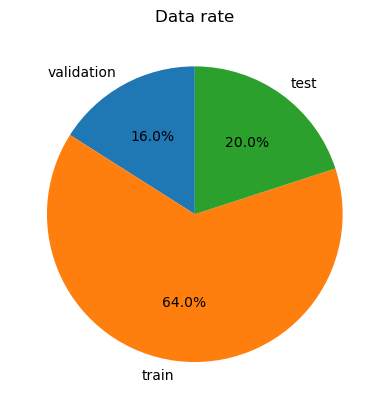

In [12]:
import matplotlib.pyplot as plt

# 데이터 예제
labels = ['validation', 'train', 'test']
sizes = [1.6, 6.4, 2]

# 파이 차트 생성
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# 차트 제목
plt.title('Data rate')

# 차트 표시
plt.show()